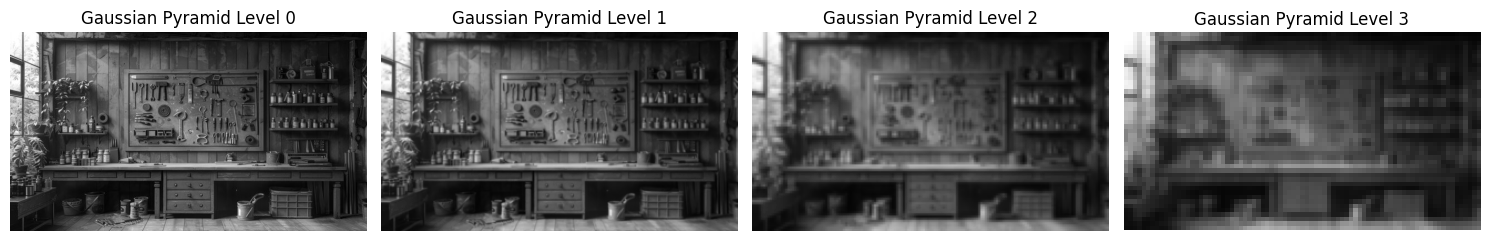

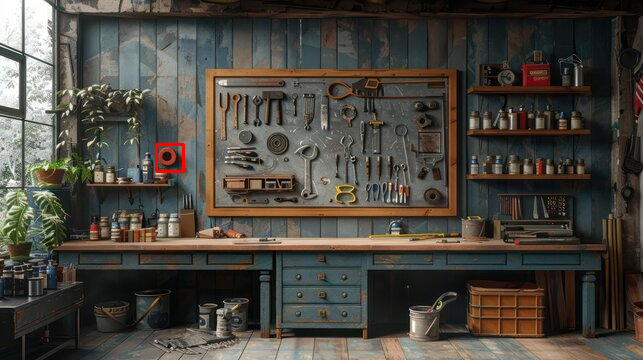

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load Images (Color for display, Grayscale for processing)
cluttered_img_color = cv2.imread('/content/cluttered.jpg', cv2.IMREAD_COLOR)  # Color image for output
cluttered_img_gray = cv2.cvtColor(cluttered_img_color, cv2.COLOR_BGR2GRAY)  # Convert to grayscale for processing
template_img = cv2.imread('/content/template.jpg', 0)  # Template remains grayscale

# Step 2: Apply Gaussian Pyramid to the grayscale cluttered image
num_levels = 4  # Define the number of pyramid levels
gaussian_pyramid = [cluttered_img_gray]
for i in range(1, num_levels):
    cluttered_img_gray = cv2.pyrDown(gaussian_pyramid[i-1])
    gaussian_pyramid.append(cluttered_img_gray)

# Plot Gaussian Pyramid Levels in a single window
fig, axes = plt.subplots(1, num_levels, figsize=(15, 5))
for i, level_img in enumerate(gaussian_pyramid):
    axes[i].imshow(level_img, cmap='gray')
    axes[i].set_title(f'Gaussian Pyramid Level {i}')
    axes[i].axis('off')  # Hide axes for clarity

plt.tight_layout()
plt.show()

# Step 3: Edge Detection using Sobel
# Apply Sobel to template image
sobel_x = cv2.Sobel(template_img, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(template_img, cv2.CV_64F, 0, 1, ksize=3)
template_edges = cv2.magnitude(sobel_x, sobel_y)
template_edges = cv2.convertScaleAbs(template_edges)  # Convert to CV_8U

# Detect edges in each level of the pyramid
pyramid_edges = []
for img in gaussian_pyramid:
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    edges = cv2.magnitude(sobel_x, sobel_y)
    edges = cv2.convertScaleAbs(edges)  # Convert to CV_8U
    pyramid_edges.append(edges)

# Step 4: Template Matching
best_match = None
best_level = 0
best_loc = None

for i, edges in enumerate(pyramid_edges):
    # Perform template matching
    result = cv2.matchTemplate(edges, template_edges, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    # Update the best match if higher correlation found
    if best_match is None or max_val > best_match:
        best_match = max_val
        best_level = i
        best_loc = max_loc

# Step 5: Highlight Detected Object
if best_loc is not None:
    # Calculate location in the original image scale
    scale_factor = 2 ** best_level
    top_left = (int(best_loc[0] * scale_factor), int(best_loc[1] * scale_factor))
    h, w = template_img.shape
    bottom_right = (top_left[0] + w * scale_factor, top_left[1] + h * scale_factor)

    # Draw rectangle on the color image
    output_image = cluttered_img_color.copy()
    cv2.rectangle(output_image, top_left, bottom_right, (0, 0, 255), 2)  # Red rectangle

    # Display final result
    from google.colab.patches import cv2_imshow
    cv2_imshow(output_image)
else:
    print("Object not detected.")

# Wait for a key press and close all windows
cv2.waitKey(0)
cv2.destroyAllWindows()


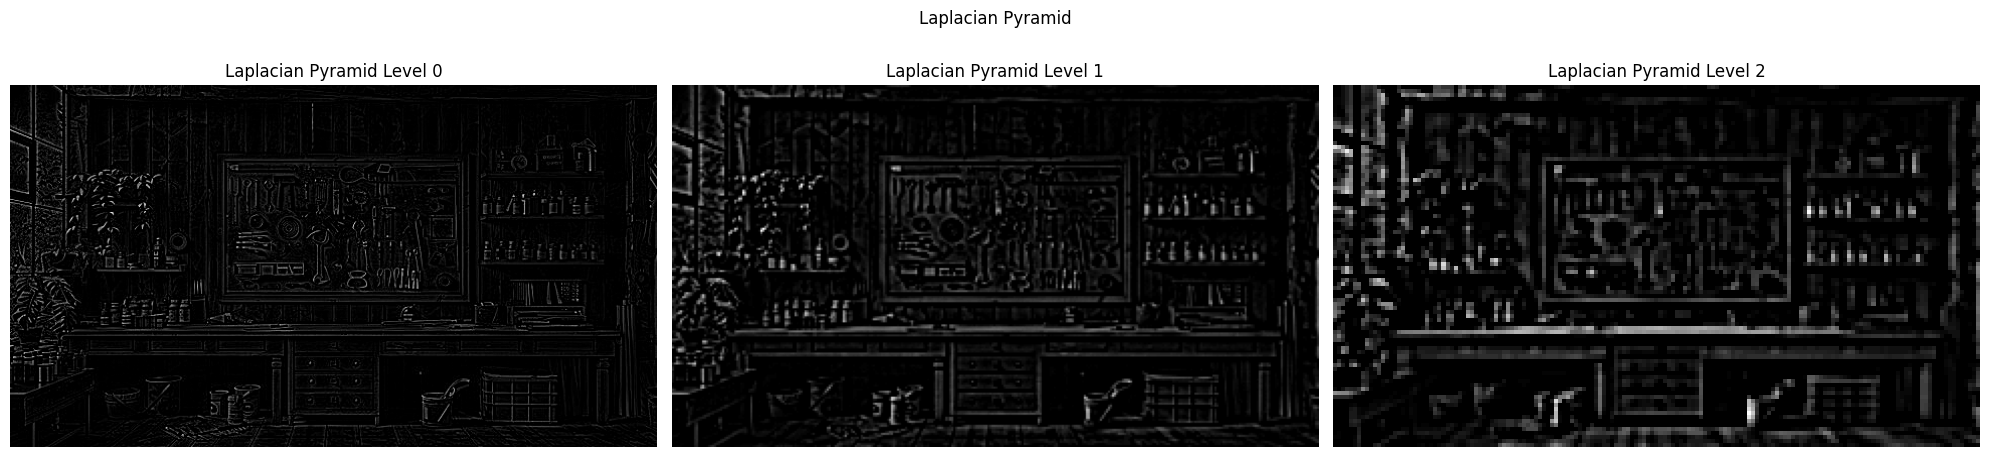

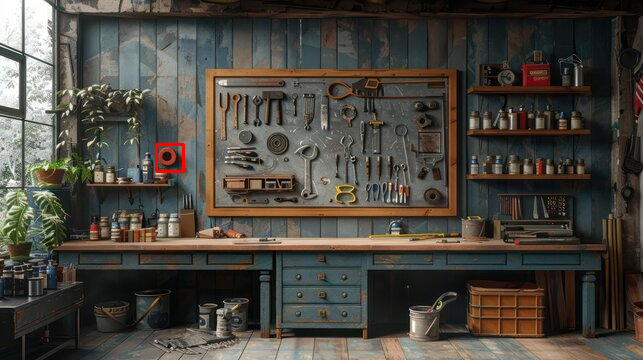

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

# Step 1: Load Images (Color for display, Grayscale for processing)
cluttered_img_color = cv2.imread('/content/cluttered.jpg', cv2.IMREAD_COLOR)  # Color image for output
cluttered_img_gray = cv2.cvtColor(cluttered_img_color, cv2.COLOR_BGR2GRAY)  # Convert to grayscale for processing
template_img = cv2.imread('/content/template.jpg', 0)  # Template remains grayscale

# Step 2: Apply Gaussian and Laplacian Pyramid to the grayscale cluttered image
num_levels = 4  # Define the number of pyramid levels
gaussian_pyramid = [cluttered_img_gray]
laplacian_pyramid = []

for i in range(1, num_levels):
    downsampled = cv2.pyrDown(gaussian_pyramid[i-1])
    gaussian_pyramid.append(downsampled)

    # Create Laplacian image
    upsampled = cv2.pyrUp(downsampled, dstsize=gaussian_pyramid[i-1].shape[::-1])
    laplacian = cv2.subtract(gaussian_pyramid[i-1], upsampled)
    laplacian_pyramid.append(laplacian)

# Step 3: Edge Detection using Prewitt Kernels and normalization
def prewitt_edges(image):
    prewitt_x = ndimage.prewitt(image, axis=0)
    prewitt_y = ndimage.prewitt(image, axis=1)
    edges = np.hypot(prewitt_x, prewitt_y)

    # Convert to an 8-bit format and normalize
    edges = np.nan_to_num(edges)  # Replace NaNs with 0 if they exist
    edges = (edges / edges.max()) * 255  # Normalize manually to 0-255
    return edges.astype(np.uint8)


template_edges = prewitt_edges(template_img)
pyramid_edges = [prewitt_edges(img) for img in gaussian_pyramid]  # Use Gaussian pyramid for edge detection

# Step 4: Template Matching
best_match = None
best_level = 0
best_loc = None

for i, edges in enumerate(pyramid_edges):
    # Perform template matching
    result = cv2.matchTemplate(edges, template_edges, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    # Update the best match if higher correlation found
    if best_match is None or max_val > best_match:
        best_match = max_val
        best_level = i
        best_loc = max_loc

# Step 5: Highlight Detected Object
if best_loc is not None:
    # Calculate location in the original image scale
    scale_factor = 2 ** best_level
    top_left = (int(best_loc[0] * scale_factor), int(best_loc[1] * scale_factor))
    h, w = template_img.shape
    bottom_right = (top_left[0] + w * scale_factor, top_left[1] + h * scale_factor)

    # Draw rectangle on the color image
    output_image = cluttered_img_color.copy()
    cv2.rectangle(output_image, top_left, bottom_right, (0, 0, 255), 2)  # Red rectangle

    # Display Laplacian Pyramid
    fig, axes = plt.subplots(1, num_levels - 1, figsize=(20, 5))
    for i, level_img in enumerate(laplacian_pyramid):
        axes[i].imshow(level_img, cmap='gray')
        axes[i].set_title(f'Laplacian Pyramid Level {i}')
        axes[i].axis('off')  # Hide axes for clarity

    plt.suptitle("Laplacian Pyramid")
    plt.tight_layout()
    plt.show()

    # Display final result
    from google.colab.patches import cv2_imshow
    cv2_imshow(output_image)
else:
    print("Object not detected.")

# Wait for a key press and close all windows
cv2.waitKey(0)
cv2.destroyAllWindows()




